In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random 
import time

In [23]:
# Function to read the instances from Taillard (1989)
def read_instances_from_file(filename):
    """Read and parse multiple Flowshop instances from a text file, extracting the processing times and lower bound."""
    times = []
    machines = []
    lower_bounds = []
    with open(filename, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith("Nb of jobs"):
                parts = list(map(int, lines[i + 1].split()))
                num_jobs, num_machines, _, _,_, lower_bound = parts
                lower_bounds.append(lower_bound)
                i += 3  # Move to processing times
                processing_times = []
                for _ in range(num_jobs):
                    processing_times.append(list(map(int, lines[i].split())))
                    i += 1
                times.append(np.array(processing_times))
                i+=1
                machines_i=[]
                for _ in range(num_jobs):
                    machines_i.append(list(map(int, lines[i].split())))
                    i += 1
                machines.append(np.array(machines_i))
                
            else:
                i += 1
    return times, machines, lower_bounds

In [24]:
#Base scenario (first instance of the 15 jobs x 15 machines)
t_all,m_all,lb_all=read_instances_from_file("tai15_15.txt")
times1=t_all[0]
machines1=m_all[0]
lb1=lb_all[0]


In [25]:
#Function to create the "schedule" - Evaluate fitness (makespan, initial_times, end_times)
def evaluate_fitness(schedule, times, machines):
    #Properties of the JSSP analyzed
    n_jobs, n_ops = times.shape
    #number of machines(as it is 0-indexed, +1 to adjust the numbering)
    n_machines = np.max(machines)+1 
    #Array to store the current machine operation end time
    machine_available = [0] * n_machines
    #array to store the current job operation end time
    job_next_op = [0] * n_jobs
    #array to store the current job end time
    job_available = [0] * n_jobs
    op_start_times = {}
    op_end_times = {}
    #Set to store the assigend operations
    processed = set()
    
    while len(processed) < n_jobs * n_ops:
        for job_id, op_id in schedule:
            #If the operation has been scheduled, next item in the schedule and it is not assigned.
            if (job_id, op_id) in processed:
                continue
            #if the operation analyzed in the schedule is not the last registered
            if op_id != job_next_op[job_id]:
                continue

            #get the machine number
            machine = machines[job_id][op_id]
            #identify which is the earliest time for scheduling: after the machine is free or after the previous activity of the job is finished
            start_time = max(machine_available[machine], job_available[job_id])
            #start_time = machine_available[machine]
            #get the operation duration
            duration = times[job_id][op_id]
            #update the end time
            end_time = start_time + duration
            #update the earliest time for the machine to be assigned
            machine_available[machine] = end_time
            #update the earliest time for the job to be resumed
            job_available[job_id] = end_time
            #update the number of operations that has been assigned in the job
            job_next_op[job_id] += 1
            #update the start time of all operations for the jobs and machines
            op_start_times[(job_id, op_id)] = start_time
            #update the end time of all operations for the jobs and machines
            op_end_times[(job_id, op_id)] = end_time
            #marks the operation/job as assigned
            processed.add((job_id, op_id))
    makespan = max(op_end_times.values()) if op_end_times else float('inf')
    return makespan, op_start_times, op_end_times

In [26]:
#adjust the numebring of machines to be 0 starting index
machines1-=1
n_jobs1, n_ops1 = times1.shape
n_machines1 = np.max(machines1)+1

#initial schedule (setting in order as originally from the instance. First job, then second and so forth)
schedule_i=[]
for j in range (n_jobs1):
    for o in machines1[j]:
        schedule_i.append((j,o))

makespan1, op_start_times1, op_end_times1 = evaluate_fitness(schedule_i, times1, machines1)
print("Makespan Basic Assignation:", makespan1)


Makespan Basic Assignation: 3267


In [27]:
def plot_schedule(schedule, op_start_times, op_end_times,machines):
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = cm.get_cmap('tab20', machines.shape[0])
    job_labels = []
    job_colors = []
    for (job, op) in schedule:
        # if job==0:
        key = (job, op)
        if key not in op_start_times:
            continue

        machine = machines[job][op] +1
        start = op_start_times[key]
        end = op_end_times[key]
        color = colors(job)
        
        ax.barh(machine, end - start, left=start, edgecolor='black', color=color)
        # ax.text(start + (end - start)/2, machine, f'J{job}-O{op}',
        #         ha='center', va='center', color='white', fontsize=7)

        if job not in job_labels:
            job_labels.append(job)
            job_colors.append(color)

    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_yticks(range(1,np.max(machines)+1+1,1))
    ax.set_title('Gantt Chart')
    ax.legend([plt.Rectangle((0,0),1,1, color=c) for c in job_colors],
              [f"Job {j+1}" for j in job_labels],
              loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
    plt.tight_layout()
    plt.show()

    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    # ax.set_yticks(range(1,np.max(machines)+1,1))
    ax.set_title('Gantt Chart')
    ax.legend([f"Job {j+1}" for j in range(machines.shape[0])], loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=5)
    plt.tight_layout()
    plt.show()

C:\Users\wilma\AppData\Local\Temp\ipykernel_21172\1776450547.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', machines.shape[0])


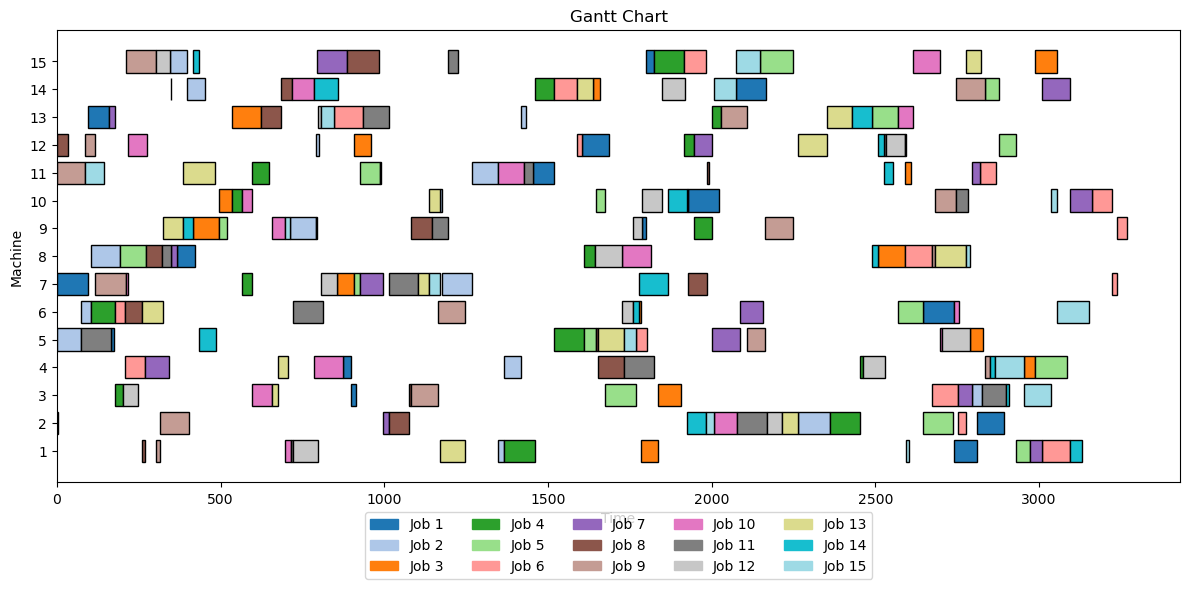

<Figure size 640x480 with 0 Axes>

In [28]:
plot_schedule(schedule_i, op_start_times1, op_end_times1,machines1)

In [29]:
#initial constructive heuristic
#based on priorizing (job,ops) based on the longest jobs to perform
def most_work_remaining_initialization(times, machines):
    n_jobs, n_ops = times.shape
    job_next_op = [0] * n_jobs #Stores the number of operations assigned per job
    job_available = [0] * n_jobs #Stores the end time for each job
    machine_available = [0] * (np.max(machines)+1) #Stores the end time for each machine
    schedule = []

    remaining = True
    while remaining:
        ready_ops = []
        for j in range(n_jobs):
            o = job_next_op[j]
            if o < n_ops:
                remaining_work = sum(times[j][o:]) #calculates the total processing time of Job j
                m = machines[j][o] 
                earliest_start = max(job_available[j], machine_available[m]) #identifies if the activity must be placed after machine is empty or after the previous op of the job is done
                ready_ops.append((-remaining_work, earliest_start, j, o))

        if not ready_ops:
            break

        ready_ops.sort()  #Sorts based on the processing time
        _, _, j, o = ready_ops[0]

        schedule.append((j, o))
        m = machines[j][o] 
        start_time = max(job_available[j], machine_available[m]) #identifies if the activity must be placed after machine is empty or after the previous op of the job is done
        end_time = start_time + times[j][o]
        job_available[j] = end_time
        machine_available[m] = end_time
        job_next_op[j] += 1

        remaining = any(op < n_ops for op in job_next_op)

    return schedule



In [30]:
schedule1x = most_work_remaining_initialization(times1, machines1)
makespan1x, start_times1x, end_times1x = evaluate_fitness(schedule1x, times1, machines1)
print("Makespan Constructive Heuristic Assignation:",makespan1x)

Makespan Constructive Heuristic Assignation: 1865


C:\Users\wilma\AppData\Local\Temp\ipykernel_21172\1776450547.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', machines.shape[0])


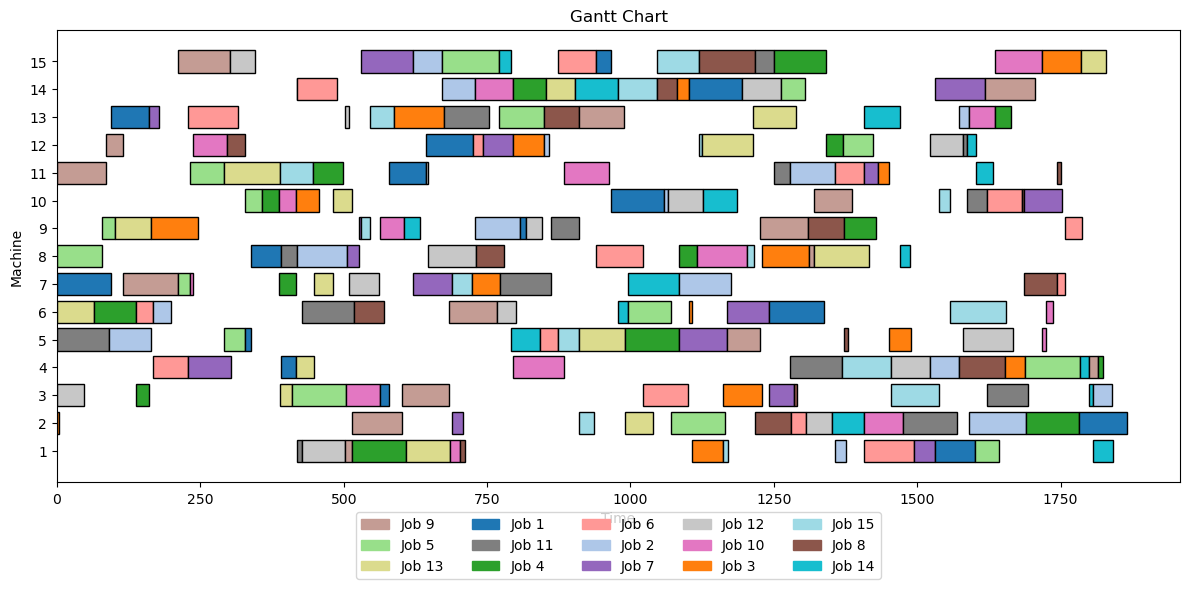

<Figure size 640x480 with 0 Axes>

In [31]:
plot_schedule(schedule1x, start_times1x, end_times1x,machines1)

In [32]:
# ------------------------
# DESTRUCTION METHODS
# ------------------------

#random destruction
def destroy_random(scheduleD, pct,n_jobs,n_machines,machines,times):
    k = int(len(scheduleD) * pct)
    removal_indices = random.sample(range(len(scheduleD)), k)
    #returns the list except the items (jobs,ops) corresponding to the k values non considered
    return [op for i, op in enumerate(scheduleD) if i not in removal_indices]

#Worst individual processing time destruction
def destroy_worst_duration(scheduleD, start_times, end_times, pct,n_jobs,n_machines,machines,times):
    k = int(len(scheduleD) * pct)
    #calculates the processing time of the pair (job,op)
    process_t = [(op, end_times[op] - start_times[op]) for op in scheduleD if op in end_times]
    #sorts the list in descending order
    sorted_ops = sorted(process_t, key=lambda x: -x[1])
    #removes the k elements with the longest processing times
    to_remove = set(op for op, _ in sorted_ops[:k])
    return [op for op in scheduleD if op not in to_remove]

#Random block destruction
def destroy_block(scheduleD, pct,n_jobs,n_machines,machines,times):
    k = int(len(scheduleD) * pct)
    #random location to remove the k elements
    start = random.randint(0, len(scheduleD) - k)
    return scheduleD[:start] + scheduleD[start + k:]

# Worst idling time element destruction
def destroy_worst_idle(scheduleD, start_times, end_times, pct,n_jobs,n_machines,machines,times):
    k = int(len(scheduleD) * pct)
    idles = []
    #stores the moment when a new job can start
    job_ready = [0] * n_jobs
    #stores the moment when each machine can theorically start 
    machine_ready = [0] * n_machines
    for (j, o) in scheduleD:
        m = machines[j][o]-1

        #theorical earliest start
        earliest_start = max(job_ready[j], machine_ready[m])
        actual_start = start_times.get((j, o), float('inf'))
        idle = actual_start - earliest_start
        idles.append(((j, o), idle))

        #update availability for simulation purposes
        job_ready[j] = actual_start + times[j][o]
        machine_ready[m] = actual_start + times[j][o]

    #sorts in descending order and removes the k elemnts with the largest idling times
    sorted_ops = sorted(idles, key=lambda x: -x[1])
    to_remove = set(op for op, _ in sorted_ops[:k])
    return [op for op in scheduleD if op not in to_remove]


# Highest used machine activity destruction
def destroy_machine_time(scheduleD, pct,n_jobs,n_machines,machines,times):
    #processing times for each machine
    time_i = [0] * n_machines
    #stores all the combiantion of (job,operation) that is processed in machine "m"
    machine_to_ops = {m: [] for m in range(n_machines)}
    #iterates over the pairs (job,ops) to sum over the machines the processing times
    for job_id, op_id in scheduleD:
        #Sets the machine to add the processing time
        machine = machines[job_id][op_id]
        time_i[machine] += times[job_id][op_id]
        machine_to_ops[machine].append((job_id, op_id))

    #defines the machine with the most work
    max_load_machine = np.argmax(time_i)
    #sets the list of operations that belong to the busiest machine
    ops_on_machine = machine_to_ops[max_load_machine]

    k = int(len(scheduleD) * pct)
    #removes the k-elements from the most used machine
    to_remove = set(random.sample(ops_on_machine, min(k, len(ops_on_machine))))
    return [op for op in scheduleD if op not in to_remove]


In [33]:
# ------------------------
# REPAIR METHODS
# ------------------------

#Shortest Processing times 
def repair_spt(scheduleR,n_jobs,n_machines,machines,times):
    remaining_ops = [(j, o) for j in range(n_jobs) for o in range(times.shape[1]) if (j, o) not in scheduleR]
    #the remaining ops from the corresponding jobs are scheduled based on the shortest processing times 
    # at the end of the schedule
    remaining_ops.sort(key=lambda x: times[x[0]][x[1]])
    return scheduleR + remaining_ops

#Random Order
def repair_random(scheduleR,n_jobs,n_machines,machines,times):
    remaining_ops = [(j, o) for j in range(n_jobs) for o in range(times.shape[1]) if (j, o) not in scheduleR]
    random.shuffle(remaining_ops)
    #the remaining ops from the corresponding jobs are scheduled randomly
    # at the end of the schedule
    return scheduleR + remaining_ops

#adds the removed sequence in a random order
def repair_random_insert(scheduleR,n_jobs,n_machines,machines,times):
    remaining_ops = [(j, o) for j in range(n_jobs) for o in range(times.shape[1]) if (j, o) not in scheduleR]
    # for the elemtns not in the list, inserts them in a random location
    for op in remaining_ops:
        idx = random.randint(0, len(scheduleR))
        scheduleR.insert(idx, op)
    return scheduleR

#Most Work Remaining
def repair_mwr(scheduleR,n_jobs,n_machines,machines,times):
    remaining_jobs = {}
    #calculates the time required to process a complete job
    for j in range(n_jobs):
        remaining = [(j, o) for o in range(times.shape[1]) if (j, o) not in scheduleR]
        if remaining:
            remaining_jobs[j] = sum(times[j][o] for _, o in remaining)
    #gets the job that has the most time pending to process and sorts the list accordingly
    ordered_jobs = sorted(remaining_jobs.items(), key=lambda x: -x[1])
    #adds the pending (job,ops) pairs based on the job priorization
    ordered_ops = [(j, o) for j, _ in ordered_jobs for o in range(times.shape[1]) if (j, o) not in scheduleR]
    return scheduleR + ordered_ops


#Most Frequent Machine First
def repair_mfmf(scheduleR,n_jobs,n_machines,machines,times):
    remaining_ops = [(j, o) for j in range(n_jobs) for o in range(times.shape[1]) if (j, o) not in scheduleR]
    machine_freq = {}
    #calculates the number of repetitions that each machine ahs in the pending to be assigned elements of the list
    for j, o in remaining_ops:
        m = machines[j][o] - 1
        machine_freq[m] = machine_freq.get(m, 0) +1
    #identifies the machines that are needed the most within the pending (job,ops)
    sorted_machines = sorted(machine_freq.items(), key=lambda x: -x[1])
    ordered_ops = []
    #adds the schedule at the end of the previous schedule based on priorizing the assignation of the machine that
    #has the largest pending work
    for m, _ in sorted_machines:
        machine_ops = [(j, o) for j, o in remaining_ops if machines[j][o] - 1 == m]
        ordered_ops.extend(machine_ops)
    return scheduleR + ordered_ops

In [34]:
# selection for the destroy/repair method based on roulette approach
def roulette_select(weights):
    total = sum(weights)
    pick = random.uniform(0, total)
    current = 0
    for i, w in enumerate(weights):
        current += w
        if current >= pick:
            return i
    return len(weights) - 1

In [35]:
#ADaptive Large Neighbourhood Search (modified with a Taboo list and a dybnamic assignation of exploration parameters: % of destruction and lambda)
def alns(schedule_input, times, machines, iterations, pct_destroy,lambda_a,taboo_tenure,cooling_rate,max_iter_n):
    destroy_ops = [destroy_random, destroy_block, destroy_machine_time,destroy_worst_duration, destroy_worst_idle]
    repair_ops = [repair_spt, repair_mwr, repair_random, repair_mfmf,repair_random_insert]
    pct=pct_destroy
    d_weights = [1.0] * len(destroy_ops)
    r_weights = [1.0] * len(repair_ops)
    psi = [10, 5, 1, 0.1]  # Reward values for: better than global, better than current, accepted worse, rejected worse
    best_schedule = list(schedule_input)
    schedule=list(schedule_input)
    best_makespan, _, _ = evaluate_fitness(best_schedule,times,machines)
    d_idx = roulette_select(d_weights)
    r_idx = roulette_select(r_weights)

    n_jobs=times.shape[0]
    n_machines=np.max(machines)+1

    taboo_list = []
    no_improve_counter = 0
    # i=0
    for i in range (iterations):
        # print("Current iteration",i)
        d_idx = roulette_select(d_weights)
        r_idx = roulette_select(r_weights)

        destroy = destroy_ops[d_idx]
        repair = repair_ops[r_idx]

        current_makespan, start_times, end_times = evaluate_fitness(schedule,times,machines)
        destroyed = destroy(schedule, pct_destroy,n_jobs,n_machines,machines,times) if 'start_times' not in destroy.__code__.co_varnames else destroy(schedule, start_times, end_times, pct_destroy,n_jobs,n_machines,machines,times)
        new_schedule = repair(destroyed,n_jobs,n_machines,machines,times)        
        new_makespan, _, _ = evaluate_fitness(new_schedule,times,machines)


        if new_makespan < best_makespan:
            best_schedule = list(new_schedule)
            best_makespan = new_makespan
            d_weights[d_idx] = lambda_a*d_weights[d_idx]+ (1-lambda_a)*psi[0]
            r_weights[r_idx] = lambda_a*r_weights[r_idx]+ (1-lambda_a)*psi[0]
            no_improve_counter = 0

        elif new_makespan < current_makespan:
            d_weights[d_idx] = lambda_a*d_weights[d_idx]+ (1-lambda_a)*psi[1]
            r_weights[r_idx] = lambda_a*r_weights[r_idx]+ (1-lambda_a)*psi[1]
            schedule = new_schedule
            no_improve_counter = 0
        else:
            accept_prob = 0.1
            if random.random() < accept_prob:
                d_weights[d_idx] = lambda_a*d_weights[d_idx]+ (1-lambda_a)*psi[2]
                r_weights[r_idx] = lambda_a*r_weights[r_idx]+ (1-lambda_a)*psi[2]
                schedule = new_schedule
            else:
                d_weights[d_idx] = lambda_a*d_weights[d_idx]+ (1-lambda_a)*psi[3]
                r_weights[r_idx] = lambda_a*r_weights[r_idx]+ (1-lambda_a)*psi[3]
            no_improve_counter += 1

        taboo_list.append(schedule)
        #Keeps the length of tabu list under the parameter tabu_tenure
        if len(taboo_list)>taboo_tenure:
            taboo_list.pop(0) #removes the oldest value to keep |T|=tabu_tenure


        if no_improve_counter >= max_iter_n:
            lambda_a /= cooling_rate
            pct = min(pct+(1-cooling_rate),1.0)

    return best_schedule


In [36]:
random.seed(10)

iterations=5000
pct_destroy=0.2
lambda_a=0.8
taboo_tenure=50
cooling_rate=1.01
max_iter_n=10
scheduleopt = alns(schedule1x, times1, machines1,iterations,pct_destroy,lambda_a,taboo_tenure,cooling_rate,max_iter_n)
makespan, start_times, end_times = evaluate_fitness(scheduleopt,times1,machines1)
print(f"Best Makespan after ALNS optimization: {makespan}")

Best Makespan after ALNS optimization: 1747


C:\Users\wilma\AppData\Local\Temp\ipykernel_21172\1776450547.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', machines.shape[0])


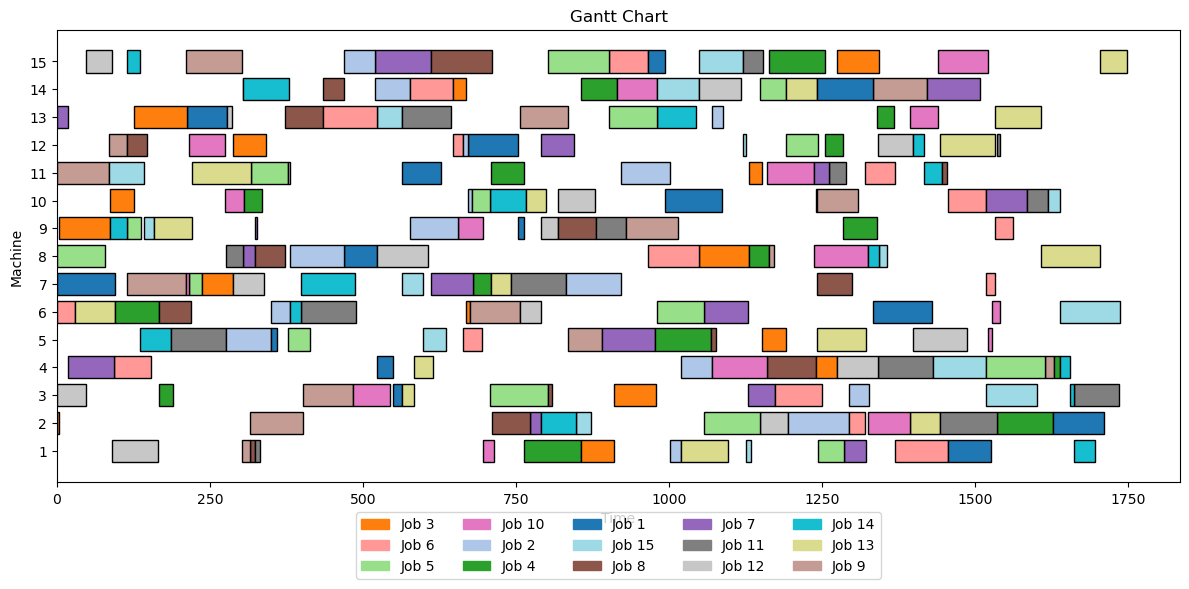

<Figure size 640x480 with 0 Axes>

In [37]:
plot_schedule(scheduleopt, start_times, end_times,machines1)

In [38]:
instance_files=["tai15_15.txt"]#,"tai20_15.txt","tai20_20.txt","tai30_15.txt","tai30_20.txt",
                # "tai50_15.txt","tai50_20.txt","tai100_20.txt"]

In [39]:
p_iterations=[2000]
p_pct_destroy=[0.2]
p_lambda_a=[0.8]
p_taboo_tenure=[10]
p_cooling_rate=[1.01]
p_max_iter_n=[10]

# Results of the Fitness function
makespan_results = []

# Schedules
schedule_results = []
idx_e=0
for iterations in p_iterations:
    for pct_destroy in p_pct_destroy:
        for lambda_a in p_lambda_a:
            for taboo_tenure in p_taboo_tenure:
                for cooling_rate in p_cooling_rate:
                    for max_iter_n in p_max_iter_n:

                        for inst, filename in enumerate(instance_files):
                            t_ins_i,m_all_i,_=read_instances_from_file(instance_files[inst])
                            for iter in range(len(t_ins_i)):
                                times=t_ins_i[iter]
                                machines=m_all_i[iter]
                                machines-=1
                                n_jobs, n_machines = times.shape
                                instance_name = f"{filename} - Instance {iter+1}"
                                print(instance_name)
                                idx_e+=1
                                print (f'Progress: {round(idx_e/(len(t_ins_i)*len(instance_files)*len(p_iterations)*len(p_pct_destroy)*len(p_lambda_a)*len(p_taboo_tenure)*len(p_cooling_rate)*len(p_max_iter_n))*100,0)}%')

                                #adjust the numbering of machines to be 0 starting index
                                t_i=time.time()
                                schedule_it= most_work_remaining_initialization(times,machines)
                                makespan0, _, _ = evaluate_fitness(schedule_it,times,machines)

                                scheduleopt = alns(schedule_it, times, machines,iterations,pct_destroy,lambda_a,taboo_tenure,cooling_rate,max_iter_n)
                                makespan, start_times, end_times = evaluate_fitness(scheduleopt,times,machines)
                                t_f=time.time()-t_i
                                
                                # Save makespan data
                                makespan_results.append({
                                    "Instance": instance_name,
                                    "n_jobs": n_jobs,
                                    "n_machines": n_machines,
                                    "p_iterations": iterations,
                                    "p_pct": pct_destroy,
                                    "p_lambda": lambda_a,
                                    "p_tabootenure": taboo_tenure,
                                    "p_cooling_r": cooling_rate,
                                    "p_max_iters_nomejor": max_iter_n,
                                    "Initial Makespan": makespan0,
                                    "Optimized Makespan": makespan,
                                    "Time (s)":t_f
                                })


# Exportar a CSV
df_makespan = pd.DataFrame(makespan_results)

df_makespan.to_csv("results_makespanSA20.csv", index=False)


tai15_15.txt - Instance 1
Progress: 10.0%
tai15_15.txt - Instance 2
Progress: 20.0%
tai15_15.txt - Instance 3
Progress: 30.0%
tai15_15.txt - Instance 4
Progress: 40.0%
tai15_15.txt - Instance 5
Progress: 50.0%
tai15_15.txt - Instance 6
Progress: 60.0%
tai15_15.txt - Instance 7
Progress: 70.0%
tai15_15.txt - Instance 8
Progress: 80.0%
tai15_15.txt - Instance 9
Progress: 90.0%
tai15_15.txt - Instance 10
Progress: 100.0%
